In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
gpus = tf.config.experimental.list_physical_devices("DML")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 1. Loading Data

In [5]:
ds = tfds.load("fashion_mnist", split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\fahri\tensorflow_datasets\fashion_mnist\3.0.1.incompleteG2IRLT\fashion_mnist-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\fahri\tensorflow_datasets\fashion_mnist\3.0.1.incompleteG2IRLT\fashion_mnist-test.tfrecord*…

Dataset fashion_mnist downloaded and prepared to C:\Users\fahri\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


# 2. Exploring Dataset

In [6]:
data_iterator = ds.as_numpy_iterator()

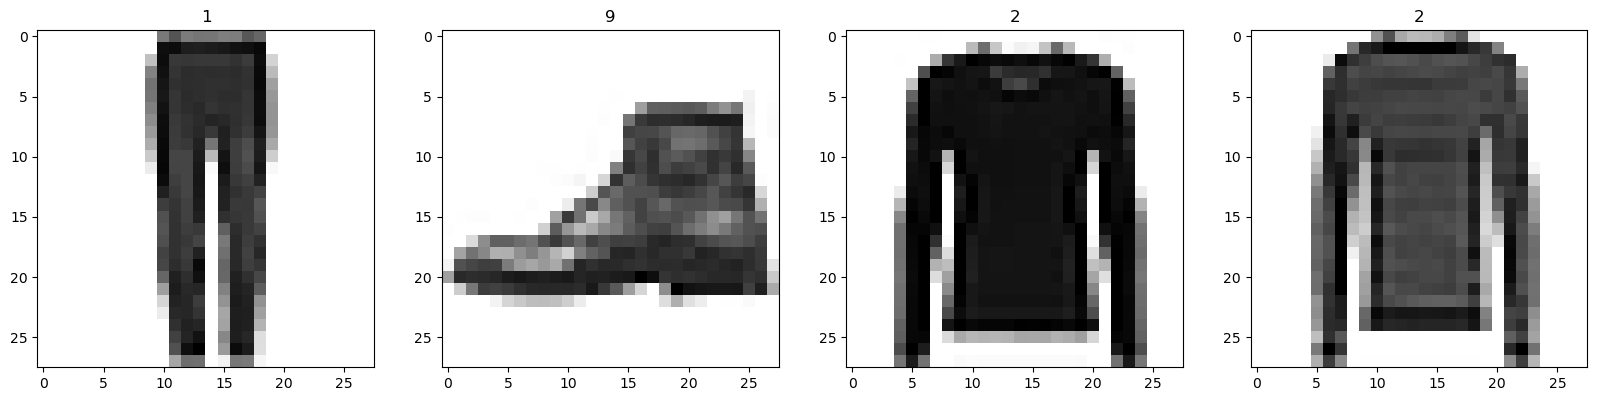

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(batch["image"]), cmap="gray_r")
    ax[idx].title.set_text(batch["label"])

# 3. Data Pipeline

In [15]:
def scale_images(data): 
    image = data['image']
    return image / 255

In [18]:
ds = tfds.load("fashion_mnist", split="train")

ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60_000)
ds = ds.batch(128)
ds = ds.prefetch(64)

# 4. Build Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

## 4.1 Generator

In [27]:
def build_generator():
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginning of generated image
    model.add( Dense( 7*7*128, input_dim=128 ) )
    model.add( LeakyReLU(0.2) )
    model.add( Reshape((7, 7, 128)) )
      
    # Upsampling block 1
    model.add( UpSampling2D() )
    model.add( Conv2D(128, 5, padding="same") )
    model.add( LeakyReLU(0.2) )
    
    # Upsampling block 2
    model.add( UpSampling2D() )
    model.add( Conv2D(128, 5, padding="same") )
    model.add( LeakyReLU(0.2) )
    
    # Convolutional block 1
    model.add( Conv2D(128, 4, padding="same") )
    model.add( LeakyReLU(0.2) )
    
    # Convolutional block 2
    model.add( Conv2D(128, 4, padding="same") )
    model.add( LeakyReLU(0.2) )
    
    # Conv Layer to get to one channel
    model.add( Conv2D(1, 4, padding="same", activation="sigmoid") )
    
    return model

generator = build_generator()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_5 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 20ms/step


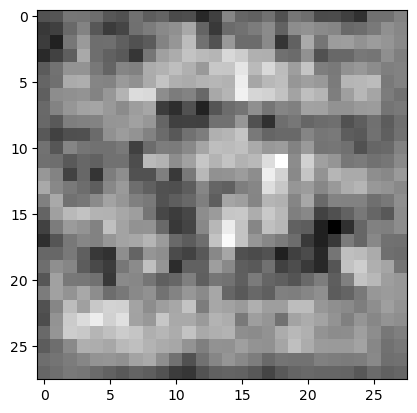

In [42]:
img = generator.predict( np.random.randn(1, 128, 1) )
image = img[0]
plt.imshow( image, cmap="gray_r" );

## 4.2 Discriminator

In [49]:
def build_discriminator():
    model = Sequential()
    
    # First Conv Block
    model.add( Conv2D(32, 5, input_shape = (28, 28, 1)) )
    model.add( LeakyReLU(0.2) )
    model.add( Dropout(0.4) )
    
    # Second Conv Block
    model.add( Conv2D(64, 5) )
    model.add( LeakyReLU(0.2) )
    model.add( Dropout(0.4) )    
    
    # Third Conv Block
    model.add( Conv2D(128, 5) )
    model.add( LeakyReLU(0.2) )
    model.add( Dropout(0.4) )    
    
    # Fourth Conv Block
    model.add( Conv2D(256, 5) )
    model.add( LeakyReLU(0.2) )
    model.add( Dropout(0.4) ) 
    
    # Flatten then pass to dense layer
    model.add( Flatten() )
    model.add( Dropout(0.4) )
    model.add( Dense(1, activation="sigmoid") )
    
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_16 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_17 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 128)     

In [52]:
discriminator.predict(img)

1/1 [==============================] - 0s 19ms/step


array([[0.50799364]], dtype=float32)

# Training

# Optimizers and Losses

In [53]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [54]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

In [55]:
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

# Build Subclassed Model

In [56]:
from tensorflow.keras.models import Model

In [68]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}
    
fashgan = FashionGAN(generator, discriminator)
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

## Build Callback

In [64]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [65]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

# Train

In [69]:
hist = fashgan.fit(ds, epochs=2000, callbacks=[ModelMonitor()])

Epoch 1/20
  8/469 [..............................] - ETA: 27:31 - d_loss: 0.6961 - g_loss: 0.6980

KeyboardInterrupt: 